## Package imports

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack
import pyarrow

In [4]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = list(stopwords.words('english'))
#stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Import data

In [5]:
data = pd.read_parquet('./input/dataframes/df_test.parquet')
data.head(10)

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,10/17/2015,VA mortgage,"Loan servicing, payments, escrow account",None,My husband and I agreed to pay off our mortgag...,Company chooses not to provide a public response,Wells Fargo & Company,PA,170XX,Older American,Consent provided,Web,10/17/2015,Closed with explanation,Yes,No,1612298
1,10/06/2015,None,Credit reporting company's investigation,No notice of investigation status/result,I am filing a complaint because EQUIFAX has ig...,None,Equifax,MI,481XX,None,Consent provided,Web,10/06/2015,Closed with explanation,Yes,No,1594610
2,01/03/2016,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,This account is fraudulent and the company ref...,None,"Receivable Recovery Services, LLC",SC,293XX,None,Consent provided,Web,01/03/2016,Closed with explanation,Yes,Yes,1726546
3,10/03/2015,Checking account,Problems caused by my funds being low,None,"Again, I lived in XXXX from : XX/XX/XXXX, unti...",Company chooses not to provide a public response,BB&T Financial,WV,257XX,"Older American, Servicemember",Consent provided,Web,10/06/2015,Closed with explanation,Yes,No,1591505
4,07/19/2015,I do not know,Communication tactics,Frequent or repeated calls,This company calls multiple times a day despit...,None,"Portfolio Recovery Associates, Inc.",NC,276XX,None,Consent provided,Web,07/19/2015,Closed with non-monetary relief,Yes,No,1473494
5,03/01/2016,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,"in 2012 I entered into a "" settlement note '' ...",Company believes complaint caused principally ...,"Dyck-O'Neal, Inc.",FL,331XX,None,Consent provided,Web,03/01/2016,Closed with explanation,Yes,Yes,1812016
6,10/05/2015,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,"Once again, I am registering a complaint again...",None,Ocwen,MO,630XX,None,Consent provided,Web,10/05/2015,Closed with explanation,Yes,Yes,1592138
7,10/26/2015,Credit card,Disclosure verification of debt,Right to dispute notice not received,I sent sample letter from CFPB requesting more...,None,Resurgent Capital Services L.P.,NC,283XX,None,Consent provided,Web,10/26/2015,Closed with explanation,Yes,Yes,1625400
8,06/20/2015,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,CITI MORTGAGE COMPLAINT : Today my broker and ...,None,Citibank,FL,341XX,None,Consent provided,Web,06/20/2015,Closed with explanation,Yes,No,1428841
9,08/10/2015,FHA mortgage,"Loan servicing, payments, escrow account",None,I have a mortgage loan with Amerihome Mortgage...,None,"AmeriHome Mortgage Company, LLC",AZ,864XX,Older American,Consent provided,Web,08/10/2015,Closed with non-monetary relief,Yes,No,1511611


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 6013 non-null   object
 1   sub_product                   4171 non-null   object
 2   issue                         6013 non-null   object
 3   sub_issue                     2964 non-null   object
 4   consumer_complaint_narrative  6013 non-null   object
 5   company_public_response       2967 non-null   object
 6   company                       6013 non-null   object
 7   state                         5999 non-null   object
 8   zipcode                       5998 non-null   object
 9   tags                          1038 non-null   object
 10  consumer_consent_provided     6013 non-null   object
 11  submitted_via                 6013 non-null   object
 12  date_sent_to_company          6013 non-null   object
 13  company_response_t

In [7]:
df_test = data.copy()

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 6013 non-null   object
 1   sub_product                   4171 non-null   object
 2   issue                         6013 non-null   object
 3   sub_issue                     2964 non-null   object
 4   consumer_complaint_narrative  6013 non-null   object
 5   company_public_response       2967 non-null   object
 6   company                       6013 non-null   object
 7   state                         5999 non-null   object
 8   zipcode                       5998 non-null   object
 9   tags                          1038 non-null   object
 10  consumer_consent_provided     6013 non-null   object
 11  submitted_via                 6013 non-null   object
 12  date_sent_to_company          6013 non-null   object
 13  company_response_t

In [9]:
df_test.shape

(6013, 17)

## Drop univariate and unneeded variables

In [10]:
df_test = df_test.drop(['consumer_consent_provided', 'submitted_via', 'complaint_id'], axis=1)

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 6013 non-null   object
 1   sub_product                   4171 non-null   object
 2   issue                         6013 non-null   object
 3   sub_issue                     2964 non-null   object
 4   consumer_complaint_narrative  6013 non-null   object
 5   company_public_response       2967 non-null   object
 6   company                       6013 non-null   object
 7   state                         5999 non-null   object
 8   zipcode                       5998 non-null   object
 9   tags                          1038 non-null   object
 10  date_sent_to_company          6013 non-null   object
 11  company_response_to_consumer  6013 non-null   object
 12  timely_response               6013 non-null   object
 13  consumer_disputed?

In [12]:
df_test.head(3)

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,10/17/2015,VA mortgage,"Loan servicing, payments, escrow account",None,My husband and I agreed to pay off our mortgag...,Company chooses not to provide a public response,Wells Fargo & Company,PA,170XX,Older American,10/17/2015,Closed with explanation,Yes,No
1,10/06/2015,None,Credit reporting company's investigation,No notice of investigation status/result,I am filing a complaint because EQUIFAX has ig...,None,Equifax,MI,481XX,None,10/06/2015,Closed with explanation,Yes,No
2,01/03/2016,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,This account is fraudulent and the company ref...,None,"Receivable Recovery Services, LLC",SC,293XX,None,01/03/2016,Closed with explanation,Yes,Yes


## Explore target value and transform with LabelEncoder

In [13]:
y_test = pd.read_parquet('./input/y_targets/y_test.parquet')
y_test.head()

,product
0,Mortgage
1,Credit reporting
2,Debt collection
3,Bank account or service
4,Debt collection


In [14]:
product = y_test['product'].value_counts()
print(product)

Debt collection            1580
Mortgage                   1343
Credit reporting           1128
Credit card                 714
Bank account or service     514
Consumer Loan               331
Student loan                191
Prepaid card                 77
Payday loan                  65
Money transfers              60
Other financial service      10
Name: product, dtype: int64


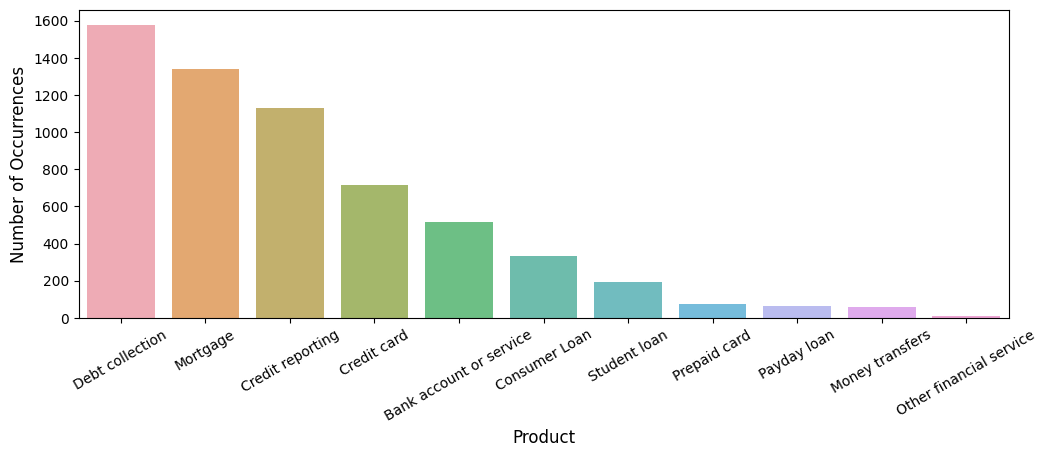

In [15]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [16]:
y_test['label'] = LabelEncoder().fit_transform(y_test['product'])

In [17]:
y_test_LE = y_test.drop(['product'], axis=1)

In [18]:
y_test_LE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   6013 non-null   int32
dtypes: int32(1)
memory usage: 23.6 KB


In [19]:
# Save label-encoded target labels
y_test_LE.to_parquet('./input/y_targets/y_test_LE.parquet')

In [20]:
# Drop original and label-encoded target dataframes from memory to mitigate potential data leakage
y_list = [y_test, y_test_LE]
del y_test, y_test_LE
del y_list

## Convert date values with datetime and create new feature for time between date_received and date_sent_to_company 

In [21]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df_test['date_received'] = np.where(
    pd.isna(df_test['date_received']) == False,
    pd.to_datetime(df_test['date_received'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [22]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df_test['date_sent_to_company'] = np.where(
    pd.isna(df_test['date_sent_to_company']) == False,
    pd.to_datetime(df_test['date_sent_to_company'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [23]:
# Create new feature that is the difference in days between when a complaint was received and when it was sent to company
df_test['days_between_receipt_and_sent'] = np.where(
    (pd.isna(df_test['date_received']) == False) & (pd.isna(df_test['date_sent_to_company']) == False),
    (df_test['date_sent_to_company'] - df_test['date_received']).dt.days,
    None
)

In [24]:
# Change new feature from datetime object to integer
df_test['days_between_receipt_and_sent'] = pd.to_numeric(df_test['days_between_receipt_and_sent'])

## Frequency encode 'sub_product' variable and add flag variables for missing/low-occurring

In [25]:
sub_product_freq = df_test.groupby('sub_product').size() / len(df_test)

In [26]:
# Vectorized operation to frequency encode sub_product category
df_test['sub_product_freq'] = np.where(
    pd.isna(df_test['sub_product']) == False,
    df_test['sub_product'].map(sub_product_freq),
    -1
)

In [27]:
# Vectorized operation to create binary flag variable for missing sub_product
df_test['sub_product_null_flag'] = np.where(
    pd.isna(df_test['sub_product']) == True,
    1,
    0
)

In [28]:
# Vectorized operation to create binary flag variable for low-occuring sub_product
df_test['sub_product_low_flag'] = np.where(
    (df_test['sub_product_freq'] <= 0.01) & (pd.isna(df_test['sub_product']) == False),
    1,
    0
)

## Frequency encode 'issue' variable and add flag variable for low-occurring

In [29]:
issue_freq = df_test.groupby('issue').size() / len(df_test)

In [30]:
# Vectorized operation to frequency encode issue category
df_test['issue_freq'] = np.where(
    pd.isna(df_test['issue']) == False,
    df_test['issue'].map(issue_freq),
    -1
)

In [31]:
# Vectorized operation to create binary flag variable for low-occuring issue
df_test['issue_low_flag'] = np.where(
    (df_test['issue_freq'] <= 0.01) & (pd.isna(df_test['issue']) == False),
    1,
    0
)

## Frequency encode 'sub_issue' variable and add flag variables for missing/low-occurring

In [32]:
sub_issue_freq = df_test.groupby('sub_issue').size() / len(df_test)

In [33]:
# Vectorized operation to frequency encode sub_issue category
df_test['sub_issue_freq'] = np.where(
    pd.isna(df_test['sub_issue']) == False,
    df_test['sub_issue'].map(sub_issue_freq),
    -1
)

In [34]:
# Vectorized operation to create binary flag variable for missing sub_issue
df_test['sub_issue_null_flag'] = np.where(
    pd.isna(df_test['sub_issue']) == True,
    1,
    0
)

In [35]:
# Vectorized operation to create binary flag variable for low-occuring sub_issue
df_test['sub_issue_low_flag'] = np.where(
    (df_test['sub_issue_freq'] <= 0.01) & (pd.isna(df_test['sub_issue']) == False),
    1,
    0
)

## Frequency encode 'company_public_response' variable and add flag variables for missing/low-occurring

In [36]:
company_public_response_freq = df_test.groupby('company_public_response').size() / len(df_test)

In [37]:
# Vectorized operation to frequency encode company_public_response category
df_test['company_public_response_freq'] = np.where(
    pd.isna(df_test['company_public_response']) == False,
    df_test['company_public_response'].map(company_public_response_freq),
    -1
)

In [38]:
# Vectorized operation to create binary flag variable for missing company_public_response
df_test['company_public_response_null_flag'] = np.where(
    pd.isna(df_test['company_public_response']) == True,
    1,
    0
)

In [39]:
# Vectorized operation to create binary flag variable for low-occuring company_public_response
df_test['company_public_response_low_flag'] = np.where(
    (df_test['company_public_response_freq'] <= 0.01) & (pd.isna(df_test['company_public_response']) == False),
    1,
    0
)

## Frequency encode 'company' variable and add flag variable for low-occurring

In [40]:
company_freq = df_test.groupby('company').size() / len(df_test)

In [41]:
# Vectorized operation to frequency encode company category
df_test['company_freq'] = np.where(
    pd.isna(df_test['company']) == False,
    df_test['company'].map(company_freq),
    -1
)

In [42]:
# Vectorized operation to create binary flag variable for low-occuring company
df_test['company_low_flag'] = np.where(
    (df_test['company_freq'] <= 0.01) & (pd.isna(df_test['company']) == False),
    1,
    0
)

## Frequency encode 'state' variable and add flag variables for missing/low-occurring

In [43]:
state_freq = df_test.groupby('state').size() / len(df_test)

In [44]:
# Vectorized operation to frequency encode state category
df_test['state_freq'] = np.where(
    pd.isna(df_test['state']) == False,
    df_test['state'].map(state_freq),
    -1
)

In [45]:
# Vectorized operation to create binary flag variable for missing state
df_test['state_null_flag'] = np.where(
    pd.isna(df_test['state']) == True,
    1,
    0
)

In [46]:
# Vectorized operation to create binary flag variable for low-occuring state
df_test['state_low_flag'] = np.where(
    (df_test['state_freq'] <= 0.01) & (pd.isna(df_test['state']) == False),
    1,
    0
)

## Frequency encode 'zipcode' variable and add flag variables for missing/low-occurring

In [47]:
zipcode_freq = df_test.groupby('zipcode').size() / len(df_test)

In [48]:
# Vectorized operation to frequency encode zipcode category
df_test['zipcode_freq'] = np.where(
    pd.isna(df_test['zipcode']) == False,
    df_test['zipcode'].map(zipcode_freq),
    -1
)

In [49]:
# Vectorized operation to create binary flag variable for missing zipcode
df_test['zipcode_null_flag'] = np.where(
    pd.isna(df_test['zipcode']) == True,
    1,
    0
)

In [50]:
# Vectorized operation to create binary flag variable for low-occuring zipcode
df_test['zipcode_low_flag'] = np.where(
    (df_test['zipcode_freq'] <= 0.001) & (pd.isna(df_test['zipcode']) == False), # change from 0.01 to 0.001 since zips are all fairly low-occurring
    1,
    0
)

## One-hot encode 'tags' variable but change nulls to "Not Older American, Not Servicemember" first

In [51]:
df_test['tags'].fillna("Not Older American, Not Servicemember", inplace=True)

In [52]:
df_test['tags'].value_counts()

Not Older American, Not Servicemember    4975
Older American                            552
Servicemember                             409
Older American, Servicemember              77
Name: tags, dtype: int64

In [53]:
OH_encoder = OneHotEncoder(dtype='int')
tags_df_test = pd.DataFrame(OH_encoder.fit_transform(df_test[['tags']]).toarray(), columns=OH_encoder.categories_[0])

In [54]:
tags_df_test.head()

,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember
0,0,1,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0


In [55]:
df_test = df_test.join(tags_df_test)

## One-hot encode 'company_response_to_consumer' variable

In [56]:
df_test['company_response_to_consumer'].value_counts()

Closed with explanation            4582
Closed with non-monetary relief     798
Closed with monetary relief         443
Closed                              142
Untimely response                    48
Name: company_response_to_consumer, dtype: int64

In [57]:
response_df_test = pd.DataFrame(OH_encoder.fit_transform(df_test[['company_response_to_consumer']]).toarray(), 
                    columns=OH_encoder.categories_[0])

In [58]:
response_df_test.head()

,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,0,1,0


In [59]:
df_test = df_test.join(response_df_test)

## Binary encode 'timely_response' variable

In [60]:
df_test['timely_response'].value_counts()

Yes    5814
No      199
Name: timely_response, dtype: int64

In [61]:
# Vectorized operation to create binary flag variable for timely_response
df_test['timely_response'] = np.where(
    df_test['timely_response'].str.contains('Yes'),
    1,
    0
)

In [62]:
df_test['timely_response'].value_counts()

1    5814
0     199
Name: timely_response, dtype: int64

## Binary encode 'consumer_disputed?' variable

In [63]:
df_test['consumer_disputed?'].value_counts()

No     4625
Yes    1388
Name: consumer_disputed?, dtype: int64

In [64]:
# Vectorized operation to create binary flag variable for consumer_disputed?
df_test['consumer_disputed?'] = np.where(
    df_test['consumer_disputed?'].str.contains('Yes'), 
    1,
    0
)

In [65]:
df_test['consumer_disputed?'].value_counts()

0    4625
1    1388
Name: consumer_disputed?, dtype: int64

In [66]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date_received                          6013 non-null   object 
 1   sub_product                            4171 non-null   object 
 2   issue                                  6013 non-null   object 
 3   sub_issue                              2964 non-null   object 
 4   consumer_complaint_narrative           6013 non-null   object 
 5   company_public_response                2967 non-null   object 
 6   company                                6013 non-null   object 
 7   state                                  5999 non-null   object 
 8   zipcode                                5998 non-null   object 
 9   tags                                   6013 non-null   object 
 10  date_sent_to_company                   6013 non-null   object 
 11  comp

In [67]:
df_test.head()

,date_received,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,2015-10-17,VA mortgage,"Loan servicing, payments, escrow account",None,My husband and I agreed to pay off our mortgag...,Company chooses not to provide a public response,Wells Fargo & Company,PA,170XX,Older American,2015-10-17,Closed with explanation,1,0,0,0.008482,0,1,0.098287,0,-1.000000,1,0,0.293032,0,0,0.043406,0,0.037086,0,0,0.001330,0,0,0,1,0,0,0,1,0,0,0
1,2015-10-06,None,Credit reporting company's investigation,No notice of investigation status/result,I am filing a complaint because EQUIFAX has ig...,None,Equifax,MI,481XX,"Not Older American, Not Servicemember",2015-10-06,Closed with explanation,1,0,0,-1.000000,1,0,0.028771,0,0.012806,0,0,-1.000000,1,0,0.061034,0,0.020289,0,0,0.005322,0,0,1,0,0,0,0,1,0,0,0
2,2016-01-03,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,This account is fraudulent and the company ref...,None,"Receivable Recovery Services, LLC",SC,293XX,"Not Older American, Not Servicemember",2016-01-03,Closed with explanation,1,1,0,0.059538,0,0,0.110095,0,0.010311,0,0,-1.000000,1,0,0.000333,1,0.013637,0,0,0.001829,0,0,1,0,0,0,0,1,0,0,0
3,2015-10-03,Checking account,Problems caused by my funds being low,None,"Again, I lived in XXXX from : XX/XX/XXXX, unti...",Company chooses not to provide a public response,BB&T Financial,WV,257XX,"Older American, Servicemember",2015-10-06,Closed with explanation,1,0,3,0.056710,0,0,0.012972,0,-1.000000,1,0,0.293032,0,0,0.004823,1,0.002994,0,1,0.000499,0,1,0,0,1,0,0,1,0,0,0
4,2015-07-19,I do not know,Communication tactics,Frequent or repeated calls,This company calls multiple times a day despit...,None,"Portfolio Recovery Associates, Inc.",NC,276XX,"Not Older American, Not Servicemember",2015-07-19,Closed with non-monetary relief,1,0,0,0.059538,0,0,0.043240,0,0.023283,0,0,-1.000000,1,0,0.009147,1,0.032762,0,0,0.002661,0,0,1,0,0,0,0,0,0,1,0


## Drop non-converted and unneeded columns to keep feature-engineered dataframe

In [68]:
# keep 'product' bc used LabelEncoder here but have used cat.code factorization previously
df_test_fe = df_test.drop(['date_received', 'sub_product', 'issue', 'sub_issue', 'company_public_response', 'company', 
                         'state', 'zipcode', 'tags', 'date_sent_to_company', 'company_response_to_consumer'], axis=1)

In [69]:
df_test_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6013 entries, 0 to 6012
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           6013 non-null   object 
 1   timely_response                        6013 non-null   int32  
 2   consumer_disputed?                     6013 non-null   int32  
 3   days_between_receipt_and_sent          6013 non-null   int64  
 4   sub_product_freq                       6013 non-null   float64
 5   sub_product_null_flag                  6013 non-null   int32  
 6   sub_product_low_flag                   6013 non-null   int32  
 7   issue_freq                             6013 non-null   float64
 8   issue_low_flag                         6013 non-null   int32  
 9   sub_issue_freq                         6013 non-null   float64
 10  sub_issue_null_flag                    6013 non-null   int32  
 11  sub_

In [70]:
df_test_fe.head()

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,My husband and I agreed to pay off our mortgag...,1,0,0,0.008482,0,1,0.098287,0,-1.000000,1,0,0.293032,0,0,0.043406,0,0.037086,0,0,0.001330,0,0,0,1,0,0,0,1,0,0,0
1,I am filing a complaint because EQUIFAX has ig...,1,0,0,-1.000000,1,0,0.028771,0,0.012806,0,0,-1.000000,1,0,0.061034,0,0.020289,0,0,0.005322,0,0,1,0,0,0,0,1,0,0,0
2,This account is fraudulent and the company ref...,1,1,0,0.059538,0,0,0.110095,0,0.010311,0,0,-1.000000,1,0,0.000333,1,0.013637,0,0,0.001829,0,0,1,0,0,0,0,1,0,0,0
3,"Again, I lived in XXXX from : XX/XX/XXXX, unti...",1,0,3,0.056710,0,0,0.012972,0,-1.000000,1,0,0.293032,0,0,0.004823,1,0.002994,0,1,0.000499,0,1,0,0,1,0,0,1,0,0,0
4,This company calls multiple times a day despit...,1,0,0,0.059538,0,0,0.043240,0,0.023283,0,0,-1.000000,1,0,0.009147,1,0.032762,0,0,0.002661,0,0,1,0,0,0,0,0,0,1,0


## Save munged and feature-engineered dataframe for modeling

In [71]:
df_test_fe.to_parquet('./input/dataframes/df_test_FE.parquet')

## NLP for validation set text

### Functions for cleaning and processing text

In [72]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    return df

In [73]:
#L = WordNetLemmatizer()
s = SnowballStemmer('english')

def wordPreProcess(sentence):
    return ' '.join([s.stem(x.lower()) for x in re.split('\W', sentence) if len(x) >= 1])

In [74]:
def getTextFeatures(df, txt, max_features=5000, ngrams=(1,2), verbose=True): #, max_features=10000
    if verbose:
        print('processing: ', txt)
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 preprocessor=wordPreProcess,
                                 max_features=max_features,
                                 binary=True,
                                 ngram_range=ngrams)
    X = vectorizer.fit_transform(df[txt])
    return X, vectorizer.get_feature_names_out()

## View and prepare text

In [75]:
for i in df_test_fe['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

My husband and I agreed to pay off our mortgage. We felt the best way to pay this off would be to start making a payment per day. Our payment amount is less than {$600.00}. We decided to pay {$600.00} each day until the mortgage was completely payed off. Understanding that we confirmed with the bank that each payment would be recognized as a monthly payment. And we would not be held responsible for payments in arrears, should either of us fall ill and not be able to make a payment during a 90 day period that would let us rest at ease that payments represented a monthly payment. We see a full months amount of interest taken out of the payment, even though we have made the payments on a daily basis. or even several payments on one day. A mortgage should be interest calculated on the days required between payments against the balance. May we please have this in writing as to why they are making this payment as principal and interest for the full month 's interest? Am I mistaken on this is

In [76]:
df_test_fe = df_test_fe.rename({'consumer_complaint_narrative':'text'},axis=1)

In [77]:
df_test_fe['text'] = df_test_fe['text'].astype(str)

In [78]:
df_test_fe.head()

,text,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,My husband and I agreed to pay off our mortgag...,1,0,0,0.008482,0,1,0.098287,0,-1.000000,1,0,0.293032,0,0,0.043406,0,0.037086,0,0,0.001330,0,0,0,1,0,0,0,1,0,0,0
1,I am filing a complaint because EQUIFAX has ig...,1,0,0,-1.000000,1,0,0.028771,0,0.012806,0,0,-1.000000,1,0,0.061034,0,0.020289,0,0,0.005322,0,0,1,0,0,0,0,1,0,0,0
2,This account is fraudulent and the company ref...,1,1,0,0.059538,0,0,0.110095,0,0.010311,0,0,-1.000000,1,0,0.000333,1,0.013637,0,0,0.001829,0,0,1,0,0,0,0,1,0,0,0
3,"Again, I lived in XXXX from : XX/XX/XXXX, unti...",1,0,3,0.056710,0,0,0.012972,0,-1.000000,1,0,0.293032,0,0,0.004823,1,0.002994,0,1,0.000499,0,1,0,0,1,0,0,1,0,0,0
4,This company calls multiple times a day despit...,1,0,0,0.059538,0,0,0.043240,0,0.023283,0,0,-1.000000,1,0,0.009147,1,0.032762,0,0,0.002661,0,0,1,0,0,0,0,0,0,1,0


## Sanitize and vectorize text

In [79]:
df_test_fe = clean_text(df_test_fe)

In [80]:
X_text_test, feat_text_test = getTextFeatures(df_test_fe, 'text')

processing:  text


c:\Miniconda\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [81]:
print(X_text_test)

  (0, 394)	0.09790457484860697
  (0, 2205)	0.09058714125691196
  (0, 670)	0.09790457484860697
  (0, 3056)	0.05797921726285243
  (0, 4107)	0.10451746794780102
  (0, 830)	0.1078349413031594
  (0, 2583)	0.10378712118571293
  (0, 4463)	0.10528345518870304
  (0, 4014)	0.08777615131394467
  (0, 822)	0.06588368993922783
  (0, 3029)	0.08065677480235954
  (0, 2371)	0.09479878502616534
  (0, 2568)	0.09121520997534659
  (0, 1463)	0.10057192587400801
  (0, 1381)	0.09220709498660092
  (0, 4067)	0.09742147137229415
  (0, 2636)	0.1078349413031594
  (0, 1082)	0.09121520997534659
  (0, 4053)	0.10451746794780102
  (0, 2555)	0.09891780537528427
  (0, 3146)	0.10242107526801689
  (0, 2795)	0.09840301748019485
  (0, 2401)	0.07215390101390423
  (0, 1514)	0.061176888714969097
  (0, 2968)	0.08968977564117933
  :	:
  (6011, 3693)	0.11790865077927785
  (6012, 2589)	0.3181247319127878
  (6012, 2594)	0.31393757471656875
  (6012, 3152)	0.24155843633869015
  (6012, 4092)	0.32271124368915205
  (6012, 3095)	0.28816739

In [82]:
#Saving the validation text features into an NPZ file
sparse.save_npz("./input/X_matrices/X_text_test.npz", X_text_test)

## Combine text matrix with engineered features from EDA

In [83]:
# get engineered features together in place
numFeatures =['timely_response', 'consumer_disputed?', 'days_between_receipt_and_sent',
              'sub_product_freq', 'sub_product_null_flag', 'sub_product_low_flag', 'issue_freq',
              'issue_low_flag', 'sub_issue_freq','sub_issue_null_flag', 'sub_issue_low_flag',
              'company_public_response_freq', 'company_public_response_null_flag', 'company_public_response_low_flag',
              'company_freq', 'company_low_flag', 'state_freq', 'state_null_flag', 'state_low_flag',
              'zipcode_freq', 'zipcode_null_flag', 'zipcode_low_flag', 'Not Older American, Not Servicemember',
              'Older American', 'Older American, Servicemember', 'Servicemember', 'Closed', 'Closed with explanation',
              'Closed with monetary relief', 'Closed with non-monetary relief', 'Untimely response']

In [84]:
X_test = hstack((X_text_test, StandardScaler().fit_transform(df_test_fe[numFeatures]))).tocsr()

In [85]:
#Saving the combined features into an NPZ file
sparse.save_npz("./input/X_matrices/X_test.npz", X_test)